In [1]:
import xarray as xr
import numpy as np
from fastjmd95 import jmd95numba
from xgcm.grid import Grid

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp_surf.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt_surf.zarr')
UVEL = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
VVEL = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
#Density = Density.assign_coords(depth=('k', RC))


In [5]:
grid = Grid(Density, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [6]:
Density_upoints = grid.interp(Density,'X')
Density_vpoints = grid.interp(Density,'Y')

In [7]:
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DXG_array = (xr.DataArray(DXG.reshape(2160,2160),dims=['j','i']).assign_coords(i=Density.i,j=Density.j))
DYG_array = (xr.DataArray(DYG.reshape(2160,2160),dims=['j','i']).assign_coords(i=Density.i,j=Density.j))
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC_array = (xr.DataArray(DXC.reshape(2160,2160),dims=['j','i_g']).assign_coords(i_g=Density_upoints.i_g,j=Density.j))
DYC_array = (xr.DataArray(DYC.reshape(2160,2160),dims=['j_g','i']).assign_coords(i=Density.i,j_g=Density_vpoints.j_g))

In [8]:
term_1 = (grid.diff(UVEL.U,'X')*(grid.diff(Density_upoints,'X'))**2)/DXG_array**3


In [9]:
term_2 = (grid.interp(grid.diff(grid.interp(VVEL.V,'X'),'X'),'Y'
                    )*grid.diff(Density_vpoints,'Y')*grid.diff(Density_upoints,'X'))/DXG_array**2/DYG_array

In [10]:
term_3 = (grid.interp(grid.diff(grid.interp(UVEL.U,'Y'),'Y'),'X'
                    )*grid.diff(Density_vpoints,'Y')*grid.diff(Density_upoints,'X'))/DXG_array/DYG_array**2

In [11]:
term_4 = grid.diff(VVEL.V,'Y')*(grid.diff(Density_vpoints,'Y'))**2/DYG_array**3

In [12]:
frontogenesis = -(term_1+term_2+term_3+term_4)

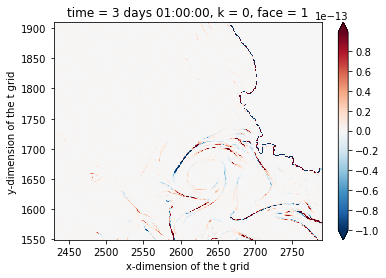

In [13]:
frontogenesis.isel(time=2).squeeze().isel(i=slice(900+450,-900+450),j=slice(900+650,-900+650)
                                          ).plot.pcolormesh(levels=np.arange(-1,1,0.01)*10**-13,rasterized=True)

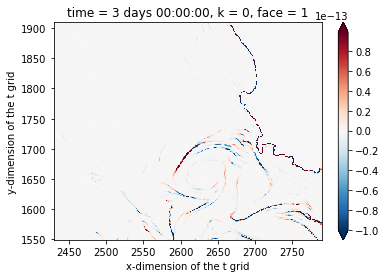

In [19]:
frontogenesis.isel(time=1).squeeze().isel(i=slice(900+450,-900+450),j=slice(900+650,-900+650)
                                          ).plot.pcolormesh(levels=np.arange(-1,1,0.01)*10**-13,rasterized=True)

In [15]:
frontogenesis_subset = frontogenesis.isel(time=slice(44,1800,24))

In [16]:
frontogenesis_subset.to_dataset(name='frontogenesis').chunk({'time':1,'k':1,'i':270,'j':270}
                                ).to_zarr('/swot/SUM02/spencer/daily_filt/frontogenesis_subset.zarr')

In [42]:
grad_Density = (grid.diff(Density_upoints,'X')/DXG_array)**2 + (grid.diff(Density_vpoints,'Y')/DYG_array)**2

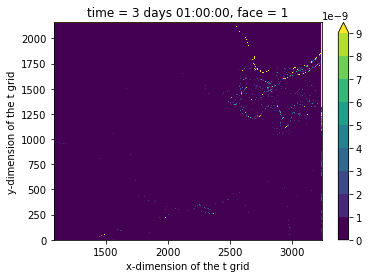

In [48]:
grad_Density.isel(time=2).plot(levels=np.arange(0,1,0.1)*10**-8)

In [66]:
advection_term = grid.interp(UVEL.U*(grid.diff(grad_Density,'X')/DXC_array).drop_vars('i_g'),'X'
                            )+grid.interp(VVEL.V*(grid.diff(grad_Density,'Y')/DYC_array).drop_vars('i'),'Y')

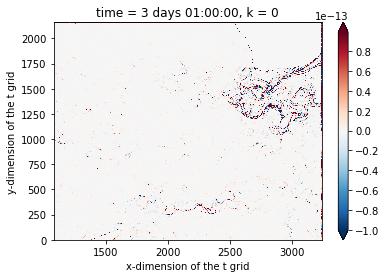

In [77]:
advection_term.isel(time=2).squeeze().plot.pcolormesh(levels=np.arange(-1,1,0.01)*10**-13,rasterized=True)

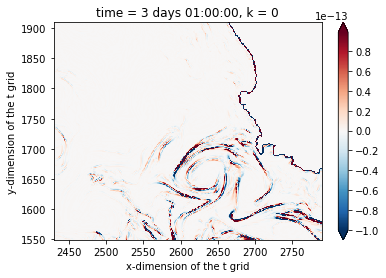

In [80]:
advection_term.isel(time=2).squeeze().isel(i=slice(900+450,-900+450),j=slice(900+650,-900+650)
                                          ).plot.pcolormesh(levels=np.arange(-1,1,0.01)*10**-13,rasterized=True)